In [13]:
import os
import re
import concurrent.futures
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from multiprocessing import cpu_count, Process

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, LabelEncoder,
                                   PolynomialFeatures, MinMaxScaler)
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Add, LSTM
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from statsmodels.tsa.holtwinters import Holt
import scipy

Missing Cities in dataframe: ['Athens', 'Antwerp', 'Rome', 'Moscow']
Missing NOCs in dataframe: ['RUS']
Remaining duplicate entries: 0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_21744\3854077895.py:208: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("NOC", group_keys=False).apply(fill_trends_for_noc)
C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_21744\3854077895.py:217: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda subdf: subdf[df_num_cols].sum(numeric_only=True))


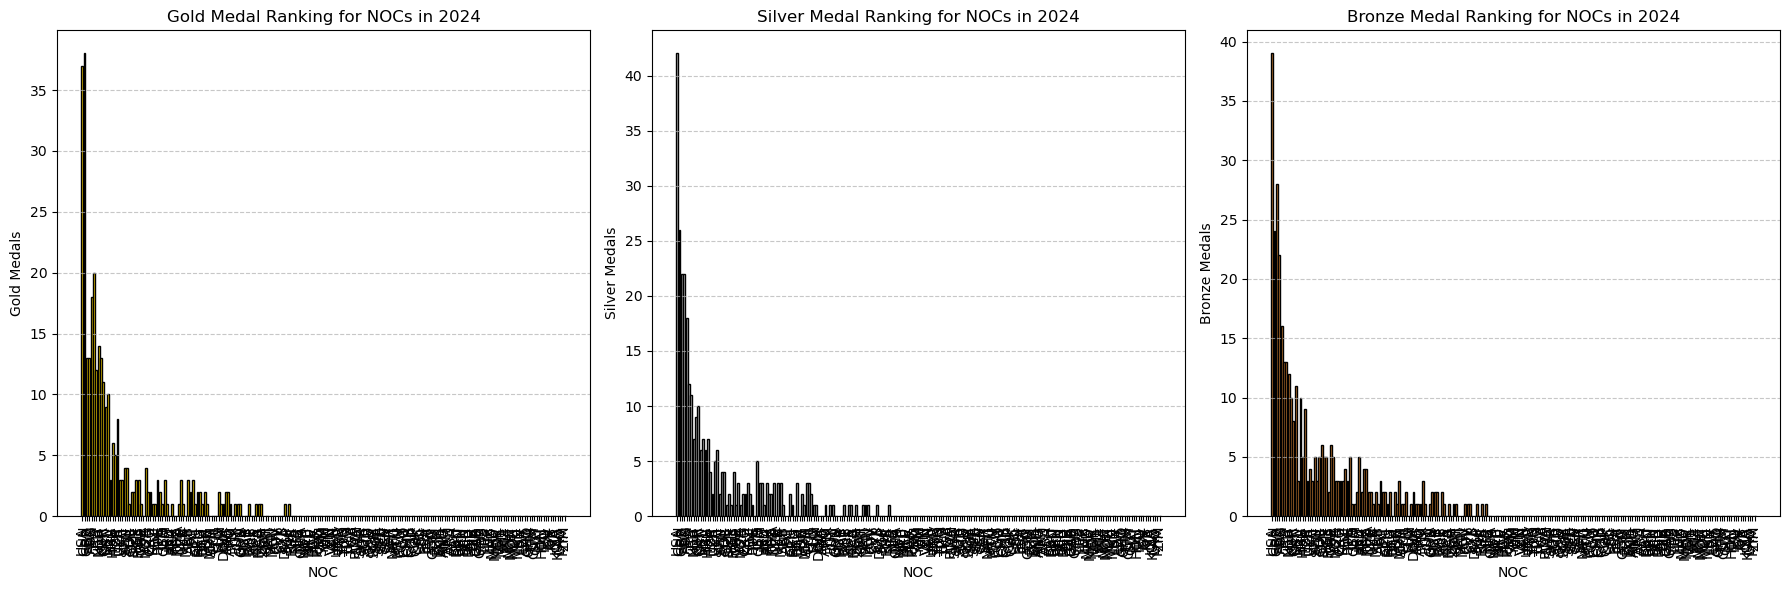

,Year,Elite_Player,EvtCount,Is_Host,Participation_Count,PlayerCount,Retiring_Player,Seed_Player,Trend_AthCount,Trend_NumEvents,...,NOC_URU,NOC_USA,NOC_UZB,NOC_VAN,NOC_VEN,NOC_VIE,NOC_VIN,NOC_YEM,NOC_ZAM,NOC_ZIM
0,1896,20.0,25.0,0.0,25.0,5.0,10.0,9.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1896,15.0,49.0,0.0,28.0,21.0,10.0,4.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1896,29.0,144.0,0.0,105.0,36.0,71.0,6.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1896,28.0,414.0,0.0,68.0,276.0,14.0,17.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1896,22.0,399.0,0.0,81.0,210.0,30.0,10.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,2024,0.0,361.0,0.0,38.0,285.0,4.0,0.0,6.991670,4.398791,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3093,2024,0.0,16.0,0.0,5.0,16.0,0.0,0.0,0.368421,0.368421,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3094,2024,0.0,16.0,0.0,4.0,16.0,0.0,0.0,-0.081633,-0.755102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3095,2024,0.0,64.0,0.0,9.0,64.0,0.0,0.0,0.703360,1.346676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
# ------------------------------------------------------------------
# 1) Enable multi-threading in TensorFlow
# ------------------------------------------------------------------
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"
tf.config.threading.set_intra_op_parallelism_threads(20)
tf.config.threading.set_inter_op_parallelism_threads(20)

# ------------------------------------------------------------------
# 2) Load & Basic Cleaning (with duplicate removal)
# ------------------------------------------------------------------
data_path = "MCM_2025\\2025_MCM-ICM_Problems\\2025_Problem_C_Data\\summerOly_athletes.csv"
df = pd.read_csv(data_path)

# Remove invalid Team entries
df = df[~df['Team'].str.contains(r'\d|\.', na=False)]
roman_pattern = r'(?:\s|-)M{0,4}(?:CM|CD|D?C{0,3})(?:XC|XL|L?X{0,3})(?:IX|IV|V?I{0,3})(?:\s|$)'
df = df[~df['Team'].str.contains(roman_pattern, na=False, flags=re.IGNORECASE)]

# Remove countries not present in the last two Olympics (2020 & 2024)
recent_years = [2020, 2024]
df = df[df["NOC"].isin(df[df["Year"].isin(recent_years)]["NOC"].unique())]

# Remove events that appeared <4 times
event_counts = df["Event"].value_counts()
df = df[df["Event"].isin(event_counts[event_counts >= 4].index)]

# Convert Year to int
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype(int)

# ------------------------------------------------------------------
# Remove duplicate records ensuring max 1 medal per event per year
# ------------------------------------------------------------------

# Sort data to prioritize Gold > Silver > Bronze in case of duplicates
df = df.sort_values(by=["Year", "NOC", "Event", "Medal"], ascending=[True, True, True, True])

# Remove duplicate medals ensuring one per NOC, Event, Year combination
df = df.drop_duplicates(subset=["Year", "NOC", "Event", "Medal"], keep="first")

# Optionally, remove exact duplicate rows across all columns
df.drop_duplicates(inplace=True)

# ------------------------------------------------------------------
# 3) Feature Engineering (Row-level)
# ------------------------------------------------------------------
df["Seed_Player"] = df.groupby("Name")["Medal"].transform(
    lambda x: (x == "Gold").cumsum() + (x == "Silver").cumsum()
).fillna(0).astype(int)

df["Elite_Player"] = df.groupby("Name")["Medal"].transform(
    lambda x: max(0, (x != "No medal").sum() - 1 + (x == "Gold").sum())
).fillna(0).astype(int)

df["Participation_Count"] = df.groupby("Name")["Year"].transform("count")
df["Retiring_Player"] = df["Participation_Count"].apply(lambda x: max(0, x - 3)).astype(int)

city_to_noc = {
    'Athens': 'GRE',
    'Paris': 'FRA',
    'St. Louis': 'USA',
    'London': 'GBR',
    'Stockholm': 'SWE',
    'Antwerp': 'BEL',
    'Amsterdam': 'NED',
    'Los Angeles': 'USA',
    'Berlin': 'GER',
    'Helsinki': 'FIN',
    'Melbourne': 'AUS',
    'Rome': 'ITA',
    'Tokyo': 'JPN',
    'Mexico City': 'MEX',
    'Munich': 'GER',
    'Montreal': 'CAN',
    'Moscow': 'RUS',
    'Seoul': 'KOR',
    'Barcelona': 'ESP',
    'Atlanta': 'USA',
    'Sydney': 'AUS',
    'Beijing': 'CHN',
    'Rio de Janeiro': 'BRA',
    'Tokyo': 'JPN',
    'Paris': 'FRA',
    'Los Angeles': 'USA'
}
# Check if all dictionary keys and values exist in the dataframe
missing_cities = [city for city in city_to_noc.keys() if city not in df['City'].unique()]
missing_nocs = [noc for noc in city_to_noc.values() if noc not in df['NOC'].unique()]

# Print missing entries
if missing_cities:
    print("Missing Cities in dataframe:", missing_cities)
else:
    print("All Cities found in dataframe.")

if missing_nocs:
    print("Missing NOCs in dataframe:", missing_nocs)
else:
    print("All NOCs found in dataframe.")

df['Is_Host'] = df.apply(lambda row: 1 if city_to_noc.get(row['City']) == row['NOC'] else 0, axis=1)

df["NOC"] = df["NOC"].astype(str)
df["Name"] = df["Name"].astype(str)

# ------------------------------------------------------------------
# Check for remaining duplicates (for verification)
# ------------------------------------------------------------------
duplicate_check = df.duplicated(subset=['Year', 'NOC', 'Event', 'Medal']).sum()
print(f"Remaining duplicate entries: {duplicate_check}")

if duplicate_check > 0:
    print(df[df.duplicated(subset=['Year', 'NOC', 'Event', 'Medal'], keep=False)])

# ------------------------------------------------------------------
# Compute trend-related features
# ------------------------------------------------------------------
def compute_trend(years, values):
    """
    Return slope in [-1..1] from linear regression, or 0 if not enough data.
    We'll do a simple approach: standardize slope to [-1..1].
    """
    if len(years) < 2:
        return 0.0
    # simple linear regression
    x = np.array(years, dtype=float).reshape(-1,1)
    y = np.array(values, dtype=float)
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression().fit(x, y)
    slope = lr.coef_[0]

    slope = max(-1.0, min(1.0, slope))  # clamp slope to [-1..1]
    return slope

df["Trend_AthCount"] = 0.0
df["Trend_NumEvents"] = 0.0
df["Trend_PlayerList"] = 0.0

def players_in_olympics(sub):
    """Helper to get unique player count for each year in that subdf."""
    return sub.groupby("Year")["Name"].nunique().reset_index(name="PlayerCount")

def events_in_olympics(sub):
    """Helper to get unique event count for each year."""
    return sub.groupby("Year")["Event"].nunique().reset_index(name="EvtCount")

def fill_trends_for_noc(sub):
    """
    sub is the subset of df for a single NOC. We'll compute the columns for each row in sub.
    We'll do the timeline approach: for each row-year, look at the last 4 data points.
    """
    sub = sub.sort_values("Year")
    # get playercount and eventcount by year
    pc = players_in_olympics(sub)  # shape=(some years, 2)
    ec = events_in_olympics(sub)

    # Merge back
    sub = sub.merge(pc, on="Year", how="left")
    sub = sub.merge(ec, on="Year", how="left")

    tAthCount = []
    tNumEvents = []
    tPlayerList = []

    # Keep a dictionary: year -> set of players
    year_to_playerset = {}
    for y in sub["Year"].unique():
        nameset = set(sub[sub["Year"]==y]["Name"])
        year_to_playerset[y] = nameset

    for i, row in sub.iterrows():
        this_year = row["Year"]
        # find up to last 4 events
        valid_years = sorted([yy for yy in sub["Year"].unique() if yy<this_year])[-4:]
        if len(valid_years)<4:
            # exclude or set 0
            tAthCount.append(0.0)
            tNumEvents.append(0.0)
        else:
            # gather (year, playerCount), do slope
            # we have row["PlayerCount"] for each row, but let's get from pc
            chunk = sub[sub["Year"].isin(valid_years)]
            year_chunk = chunk["Year"].values
            pcount_chunk = chunk["PlayerCount"].values
            ecount_chunk = chunk["EvtCount"].values

            # slope for pcount
            tAthCount.append(compute_trend(year_chunk, pcount_chunk))
            # slope for ecount
            tNumEvents.append(compute_trend(year_chunk, ecount_chunk))

        # Trend of player list: overlap from last Olympics
        prior_year = this_year - 4
        if prior_year in year_to_playerset:
            overlap = len(year_to_playerset[this_year] & year_to_playerset[prior_year])
            denom = len(year_to_playerset[this_year])
            # ratio
            ratio = overlap/denom if denom>0 else 0.0
            tPlayerList.append(ratio)
        else:
            tPlayerList.append(0.0)

    sub["Trend_AthCount"] = tAthCount
    sub["Trend_NumEvents"] = tNumEvents
    sub["Trend_PlayerList"] = tPlayerList
    return sub

df = df.groupby("NOC", group_keys=False).apply(fill_trends_for_noc)

# ------------------------------------------------------------------
# 4) Aggregation by (Year, NOC)
# ------------------------------------------------------------------
df_num_cols = df.select_dtypes(include=["number"]).columns.difference(["Year"]).tolist()

df_noc_year = (
    df.groupby(["Year", "NOC"], as_index=False)
      .apply(lambda subdf: subdf[df_num_cols].sum(numeric_only=True))
      .reset_index(drop=True)
)

# Summation of medal counts
medal_counts = df.groupby(["Year", "NOC"])["Medal"].value_counts().unstack(fill_value=0).reset_index()
medal_counts.rename(columns={"Gold": "Medal_Gold", "Silver": "Medal_Silver", "Bronze": "Medal_Bronze"}, inplace=True)

df_noc_year = df_noc_year.merge(
    medal_counts, on=["Year", "NOC"], how="left"
).fillna(0)

# ------------------------------------------------------------------
# 5) One-Hot Encoding NOC
# ------------------------------------------------------------------
ohe_noc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_noc = ohe_noc.fit_transform(df_noc_year[["NOC"]])
noc_ohe_cols = [f"NOC_{cat}" for cat in ohe_noc.categories_[0]]

df_noc_year.reset_index(drop=True, inplace=True)
noc_ohe_df = pd.DataFrame(encoded_noc, columns=noc_ohe_cols)
df_noc_year_ohe = pd.concat([df_noc_year.drop(columns=["NOC"]), noc_ohe_df], axis=1)

with open("noc_encoder.pkl", "wb") as f:
    pickle.dump(ohe_noc, f)

# ------------------------------------------------------------------
# 6) Scaling
# ------------------------------------------------------------------
target_cols = ["Medal_Gold", "Medal_Silver", "Medal_Bronze"]
feature_cols = df_noc_year_ohe.columns.difference(["Year"] + target_cols)

scaler_features = StandardScaler()
scaler_targets = StandardScaler()

X_all = scaler_features.fit_transform(df_noc_year_ohe[feature_cols])
y_all = scaler_targets.fit_transform(df_noc_year_ohe[target_cols])

with open("scaler_features.pkl", "wb") as f:
    pickle.dump(scaler_features, f)
with open("scaler_targets.pkl", "wb") as f:
    pickle.dump(scaler_targets, f)

# Keep a reference to unscaled aggregator
df_unscaled = df_noc_year_ohe.copy()

# ------------------------------------------------------------------
# 7) Visualizing Medal Distributions for 2024
# ------------------------------------------------------------------
df_2024 = df_noc_year_ohe[df_noc_year_ohe["Year"] == 2024]

noc_labels = ohe_noc.inverse_transform(df_2024[noc_ohe_cols]).flatten()
gold_medals_2024 = df_2024["Medal_Gold"].values
silver_medals_2024 = df_2024["Medal_Silver"].values
bronze_medals_2024 = df_2024["Medal_Bronze"].values

total_medals_2024 = gold_medals_2024 + silver_medals_2024 + bronze_medals_2024
sorted_indices_2024 = np.argsort(-total_medals_2024)
noc_labels_sorted_2024 = noc_labels[sorted_indices_2024]
gold_medals_sorted_2024 = gold_medals_2024[sorted_indices_2024]
silver_medals_sorted_2024 = silver_medals_2024[sorted_indices_2024]
bronze_medals_sorted_2024 = bronze_medals_2024[sorted_indices_2024]

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.bar(noc_labels_sorted_2024, gold_medals_sorted_2024, color='gold', edgecolor='black')
plt.title("Gold Medal Ranking for NOCs in 2024")
plt.xlabel("NOC")
plt.ylabel("Gold Medals")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
plt.bar(noc_labels_sorted_2024, silver_medals_sorted_2024, color='silver', edgecolor='black')
plt.title("Silver Medal Ranking for NOCs in 2024")
plt.xlabel("NOC")
plt.ylabel("Silver Medals")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)
plt.bar(noc_labels_sorted_2024, bronze_medals_sorted_2024, color='#CD7F32', edgecolor='black')
plt.title("Bronze Medal Ranking for NOCs in 2024")
plt.xlabel("NOC")
plt.ylabel("Bronze Medals")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

df_noc_year_ohe

In [5]:
# ------------------------------------------------------------------
# Weighted MAE Function
# ------------------------------------------------------------------
def weighted_mae_loss(y_true, y_pred):
    row_sum = tf.reduce_sum(tf.abs(y_true), axis=1, keepdims=True)
    weight = 1.0 + row_sum
    mae = tf.reduce_mean(weight * tf.abs(y_true - y_pred))
    return mae

# ------------------------------------------------------------------
# 7) Define final medal model using Weighted MAE
# ------------------------------------------------------------------
def build_medal_prediction_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(2048, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Dense(128, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)

    x = Dense(64, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

    x = Dense(32, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

    outputs = Dense(3, activation="linear")(x)
    model = Model(inputs, outputs)

    optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)
    model.compile(optimizer=optimizer, loss=weighted_mae_loss, metrics=["mae"])
    return model

# ------------------------------------------------------------------
# Monte Carlo Dropout: pass training_phase=1 to keep dropout active
# ------------------------------------------------------------------
def mc_dropout_predictions(model, X_input, n_simulations=1000, scale_factor=10, dropout_rate_override=0.5):
    """
    Perform Monte Carlo Dropout inference to estimate confidence intervals.
    Return mean, lower bound, and upper bound for 3D predictions.
    """

    @tf.function
    def f_model(X_input, training):
        for layer in model.layers:
            if isinstance(layer, Dropout):
                layer.rate = dropout_rate_override
        return model(X_input, training=training)

    preds = []
    for _ in range(n_simulations):
        pred = f_model(X_input, training=True)
        preds.append(pred.numpy())

    preds = np.array(preds)  # shape (n_simulations, batch, 3)
    pred_mean = np.mean(preds, axis=0)

    ci_lower = np.percentile(preds, 2.5, axis=0) * scale_factor  # Widened CI
    ci_upper = np.percentile(preds, 97.5, axis=0) * scale_factor  # Widened CI

    return pred_mean, ci_lower, ci_upper


# ------------------------------------------------------------------
# Function to train, save, and evaluate the model
# ------------------------------------------------------------------
def train_and_save_model(X_train, y_train, model_save_path="my_medal_model.h5"):
    """
    Train the model on X_train,y_train, then save to model_save_path.
    Return the trained model.
    """
    model = build_medal_prediction_model(X_train.shape[1])
    es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    rlr= ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, verbose=1)

    # simple approach: no TSCV here, 
    # or do TSCV -> final fit -> model.save
    model.fit(X_train, y_train, epochs=300, batch_size=32, verbose=2, callbacks=[es, rlr])
    
    # Save
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")
    return model

def evaluate_monte_carlo_coverage(model_path, X_2024, df_2024, noc_ohe_cols, ohe_noc, actual_2024=None, target_cols=None, n_sim=1000):
    """
    Load saved model from model_path, do MC dropout predictions on X_2024,
    compute coverage rate if actual data is provided, and visualize box plots.
    """
    # 1) Load the trained model
    loaded_model = load_model(model_path, custom_objects={"weighted_mae_loss": weighted_mae_loss})
    print(f"[Coverage] Loaded model from {model_path}")

    # 2) MC dropout 
    pred_mean, ci_lower, ci_upper = mc_dropout_predictions(loaded_model, X_2024, n_simulations=n_sim)
    
    # Decode the NOC codes from the one-hot encoded columns
    noc_labels = ohe_noc.inverse_transform(df_2024[noc_ohe_cols]).flatten()

    # If actual data is available, calculate coverage
    if actual_2024 is not None and target_cols is not None:
        coverage_mask = (actual_2024 >= ci_lower) & (actual_2024 <= ci_upper)
        coverage_each_medal = coverage_mask.mean(axis=0) * 100  # per column

        print("Coverage Rate (%) for each medal type (Gold, Silver, Bronze):")
        for i, col in enumerate(target_cols):
            print(f"{col}: {coverage_each_medal[i]:.2f}%")

        # Bar chart for coverage
        plt.figure(figsize=(8, 6))
        plt.bar(target_cols, coverage_each_medal, color='dodgerblue', edgecolor='black')
        plt.ylim(0, 100)
        plt.xlabel("Medal Type")
        plt.ylabel("Coverage Rate (%)")
        plt.title("Coverage Rate of Monte Carlo Dropout Intervals")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    
    # 3) Box Plot Visualization for Top 20 NOCs
    medal_types = ["Gold", "Silver", "Bronze"]
    total_medals = pred_mean.sum(axis=1)
    top_20_indices = np.argsort(-total_medals)[:20]  # Get top 20 by total predicted medals

    # Prepare data for boxplot with correct NOC codes
    boxplot_data = []
    for idx in top_20_indices:
        noc_code = noc_labels[idx]  # Retrieve the correct NOC code
        for i, medal in enumerate(medal_types):
            boxplot_data.append({
                "NOC": noc_code,
                "Medal": medal,
                "Lower": ci_lower[idx, i],
                "Upper": ci_upper[idx, i],
                "Predicted": pred_mean[idx, i]
            })
    df_boxplot = pd.DataFrame(boxplot_data)

    # Splitting into two groups for visualization
    split_index = 10
    top_10 = df_boxplot[df_boxplot['NOC'].isin(df_boxplot['NOC'].unique()[:split_index])]
    bottom_10 = df_boxplot[df_boxplot['NOC'].isin(df_boxplot['NOC'].unique()[split_index:])]
    
    plt.figure(figsize=(18, 8))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=top_10, x="NOC", y="Predicted", hue="Medal")
    plt.title("Confidence Intervals for Top 10 NOCs")
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)
    sns.boxplot(data=bottom_10, x="NOC", y="Predicted", hue="Medal")
    plt.title("Confidence Intervals for 11-20 Ranked NOCs")
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------------
# 8) LSTM Baseline Model
# ------------------------------------------------------------------
def build_lstm_baseline_model(x_vals, y_vals, noc, feature, n_lag=5):
    if len(x_vals) < n_lag + 1:
        print(f"[LSTM Info] Insufficient data for NOC: {noc}, Feature: {feature}")
        return None

    x_array = np.array(x_vals).reshape(-1, 1)
    y_array = np.array(y_vals).reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaled = scaler.fit_transform(y_array)

    X_seq, Y_seq = [], []
    for i in range(n_lag, len(y_scaled)):
        X_seq.append(y_scaled[i - n_lag:i])
        Y_seq.append(y_scaled[i])
    X_seq, Y_seq = np.array(X_seq), np.array(Y_seq)


    model = Sequential([
        Input(shape=(n_lag, 1)),
        LSTM(16, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    model.fit(
        X_seq,
        Y_seq,
        epochs=30,
        batch_size=4,
        verbose=0,
        use_multiprocessing=True,
        workers=20
    )
    print(f"[LSTM Info] Completed LSTM training for NOC={noc}, Feature={feature}")

    return model, scaler

def predict_lstm_value(model, scaler, x_vals, y_vals, x_target, noc, feature, n_lag=5):
    y_array = np.array(y_vals).reshape(-1, 1)
    y_scaled = scaler.transform(y_array)

    if len(y_scaled) < n_lag:
        print(f"[LSTM Warning] Not enough data to predict for NOC={noc}, Feature={feature}")
        return 0.0

    X_input = y_scaled[-n_lag:].reshape(1, n_lag, 1)
    y_pred_sc = model.predict(X_input, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_sc)
    return y_pred[0][0]

def build_baseline_model(x_vals, y_vals, noc="Unknown", feature="Unknown"):
    ret = build_lstm_baseline_model(x_vals, y_vals, noc, feature)
    if ret is None:
        return None
    return ("LSTM", ret)

def predict_baseline_value(model_info, x_target, x_vals=None, y_vals=None, noc="Unknown", feature="Unknown"):
    if model_info is None:
        return 0.0
    name, (model, scaler) = model_info
    if name == "LSTM":
        return predict_lstm_value(model, scaler, x_vals, y_vals, x_target, noc, feature)
    return 0.0

# ------------------------------------------------------------------
# Helpers for bounding sums after baseline and after medal prediction
# ------------------------------------------------------------------
def get_last_year_sum_for_noc(df_agg, noc_col, numeric_feats, last_year):
    """
    Sums the numeric_feats in the aggregator for the given NOC, year=last_year.
    If not found, return None. 
    We assume aggregator has 'NOC_{code}' columns and 'Year'. 
    """
    row = df_agg[(df_agg["Year"]==last_year) & (df_agg[noc_col]==1)]
    if row.empty:
        return None
    return row[numeric_feats].sum(axis=1).values[0]

def get_last_medal_sum_for_noc(df_agg, noc_col, last_year):
    """
    Sums the predicted medal columns for the given NOC in last_year. 
    Return that sum or None if not found.
    """
    row = df_agg[(df_agg["Year"]==last_year) & (df_agg[noc_col]==1)]
    if row.empty:
        return None
    gold = row["Medal_Gold"].values[0]
    silver = row["Medal_Silver"].values[0]
    bronze = row["Medal_Bronze"].values[0]
    return gold + silver + bronze

# ------------------------------------------------------------------
# TSCV final training for year <2024
# ------------------------------------------------------------------
def timeseries_cv_train(X_train, y_train, scaler_targets, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_results=[]
    es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    rlr= ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, verbose=1)

    for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_train)):
        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]

        model_cv= build_medal_prediction_model(X_tr.shape[1])
        model_cv.fit(X_tr,y_tr, epochs=300, batch_size=16,
                     validation_data=(X_val,y_val),
                     callbacks=[es, rlr], verbose=2)

        val_preds_sc = model_cv.predict(X_val)
        val_preds= scaler_targets.inverse_transform(val_preds_sc)
        val_actual= scaler_targets.inverse_transform(y_val)

        val_mae = np.mean(np.abs(val_preds- val_actual))
        cv_results.append(val_mae)
        print(f"[TSCV] Fold {fold+1} => MAE={val_mae:.3f}")

    print(f"[TSCV] Average CV MAE={np.mean(cv_results):.3f}")

    final_model= build_medal_prediction_model(X_train.shape[1])
    final_model.fit(X_train,y_train, epochs=300, batch_size=32, verbose=2, callbacks=[es])
    return final_model

def train_up_to_2024(X_all, y_all, df_agg):
    mask= (df_agg["Year"]<2024)
    X_train_2024= X_all[mask]
    y_train_2024= y_all[mask]
    model_2024= timeseries_cv_train(X_train_2024, y_train_2024, scaler_targets, 3)
    return model_2024

# ------------------------------------------------------------------
# 8) LSTM Baseline Model
# ------------------------------------------------------------------
def build_lstm_baseline_model(x_vals, y_vals, noc, feature, n_lag=5):
    if len(x_vals) < n_lag + 1:
        print(f"[LSTM Info] Insufficient data for NOC: {noc}, Feature: {feature}")
        return None

    x_array = np.array(x_vals).reshape(-1, 1)
    y_array = np.array(y_vals).reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaled = scaler.fit_transform(y_array)

    X_seq, Y_seq = [], []
    for i in range(n_lag, len(y_scaled)):
        X_seq.append(y_scaled[i - n_lag:i])
        Y_seq.append(y_scaled[i])
    X_seq, Y_seq = np.array(X_seq), np.array(Y_seq)


    model = Sequential([
        Input(shape=(n_lag, 1)),
        LSTM(16, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_seq, Y_seq, epochs=30, batch_size=4, verbose=0)

    return model, scaler

def predict_lstm_value(model, scaler, x_vals, y_vals, x_target, noc, feature, n_lag=5):
    y_array = np.array(y_vals).reshape(-1, 1)
    y_scaled = scaler.transform(y_array)

    if len(y_scaled) < n_lag:
        print(f"[LSTM Warning] Not enough data to predict for NOC={noc}, Feature={feature}")
        return 0.0

    X_input = y_scaled[-n_lag:].reshape(1, n_lag, 1)
    y_pred_sc = model.predict(X_input, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_sc)
    print(f"[LSTM Info] LSTM predicted for NOC={noc}, Feature={feature}")
    return y_pred[0][0]

def build_baseline_model(x_vals, y_vals, noc="Unknown", feature="Unknown"):
    ret = build_lstm_baseline_model(x_vals, y_vals, noc, feature)
    if ret is None:
        return None
    return ("LSTM", ret)

def predict_baseline_value(model_info, x_target, x_vals=None, y_vals=None, noc="Unknown", feature="Unknown"):
    if model_info is None:
        return 0.0
    name, (model, scaler) = model_info
    if name == "LSTM":
        return predict_lstm_value(model, scaler, x_vals, y_vals, x_target, noc, feature)
    return 0.0

# ------------------------------------------------------------------
# build_baseline_and_predict_2024
# ------------------------------------------------------------------
def build_baseline_and_predict_2024(model, df_agg, feature_cols, target_cols, scaler_features, scaler_targets):
    df_2024 = df_agg[df_agg["Year"] == 2020].copy()  # building from 2020
    df_2024["Year"] = 2024
    noc_cols = [c for c in df_agg.columns if c.startswith("NOC_")]

    df_agg["NOC"] = df_agg[noc_cols].idxmax(axis=1).str.replace("NOC_", "")
    df_2024["NOC"] = df_2024[noc_cols].idxmax(axis=1).str.replace("NOC_", "")

    if "NOC_FRA" in df_2024.columns:
        df_2024["Is_Host"] = df_2024["NOC_FRA"]

    numeric_feats = [c for c in feature_cols if c not in noc_cols and c != "Year" and c != "Is_Host" and c != "No medal"]

    hist_data = df_agg[df_agg["Year"] < 2024].copy()
    hist_data["NOC"] = hist_data[noc_cols].idxmax(axis=1).str.replace("NOC_", "")

    # 1) Fill LSTM baseline
    for feat in numeric_feats:
        pivot_df = hist_data.pivot(index="NOC", columns="Year", values=feat).fillna(0)
        for idx_noc in pivot_df.index:
            xvals = np.array(pivot_df.columns, dtype=float)
            yvals = pivot_df.loc[idx_noc].values
            if len(xvals) < 2:
                continue
            baseline_info = build_baseline_model(xvals, yvals, noc=idx_noc, feature=feat)
            val_2024 = predict_baseline_value(baseline_info, 2024, xvals, yvals, noc=idx_noc, feature=feat)
            noc_col = f"NOC_{idx_noc}"
            if noc_col in df_2024.columns:
                df_2024.loc[df_2024[noc_col] == 1, feat] = val_2024

    # 2) Enforce ±30% bounding on the sum of numeric_feats per NOC
    for idx_noc in df_2024["NOC"].unique():
        noc_col = f"NOC_{idx_noc}"
        sub_idx = (df_2024[noc_col] == 1)
        if not sub_idx.any():
            continue
        predicted_sum = df_2024.loc[sub_idx, numeric_feats].sum(axis=1).values[0]
        last_sum = get_last_year_sum_for_noc(df_agg, noc_col, numeric_feats, 2020)
        if last_sum is None or last_sum <= 0:
            continue
        lower_bound = 0.70 * last_sum
        upper_bound = 1.30 * last_sum
        if predicted_sum < lower_bound or predicted_sum > upper_bound:
            factor = np.clip(last_sum / predicted_sum, 0.70, 1.30)
            df_2024.loc[sub_idx, numeric_feats] *= factor
            print(f"[Baseline Bound] NOC={idx_noc}, old_sum={predicted_sum:.2f}, new_sum={predicted_sum * factor:.2f}, factor={factor:.3f}")

    for col in df_agg.columns:
        if col not in df_2024.columns:
            df_2024[col] = 0

    X_2024_unsc = df_2024[feature_cols].values
    X_2024_sc = scaler_features.transform(X_2024_unsc)
    preds_2024_sc = model.predict(X_2024_sc)
    preds_2024 = scaler_targets.inverse_transform(preds_2024_sc)

    df_real_2024 = df_agg[df_agg["Year"] == 2024].reset_index(drop=True)
    df_real_2024["NOC"] = df_real_2024[noc_cols].idxmax(axis=1).str.replace("NOC_", "")

    actual_2024 = df_real_2024[target_cols].values

    # 3) Rounding values before rescaling
    gold_pred, silver_pred, bronze_pred = preds_2024[:, 0], preds_2024[:, 1], preds_2024[:, 2]

    for i in range(len(df_2024)):
        gold_pred[i] = 0 if gold_pred[i] < 0.6 else round(gold_pred[i])
        silver_pred[i] = 0 if silver_pred[i] < 0.6 else round(silver_pred[i])
        bronze_pred[i] = 0 if bronze_pred[i] < 0.6 else round(bronze_pred[i])

    # 4) Rescale medal predictions with integer values
    for i in range(len(df_2024)):
        row_noc = df_2024["NOC"].iloc[i]
        noc_col = f"NOC_{row_noc}"
        last_medal_sum = get_last_medal_sum_for_noc(df_agg, noc_col, 2020)
        if last_medal_sum is None or last_medal_sum <= 0:
            continue
        sum_pred = gold_pred[i] + silver_pred[i] + bronze_pred[i]
        lowerb = 0.85 * last_medal_sum
        upperb = 1.15 * last_medal_sum
        if sum_pred < lowerb or sum_pred > upperb:
            factor = np.clip(last_medal_sum / sum_pred, 0.85, 1.15)
            gold_pred[i] = round(gold_pred[i] * factor)
            silver_pred[i] = round(silver_pred[i] * factor)
            bronze_pred[i] = round(bronze_pred[i] * factor)
            print(f"[Medal Bound] NOC={row_noc}, old_sum={sum_pred:.2f}, new_sum={sum_pred * factor:.2f}, factor={factor:.3f}")

    final_preds_2024 = np.vstack([gold_pred, silver_pred, bronze_pred]).T

    df_res_2024 = pd.DataFrame({
        "NOC": df_real_2024["NOC"].astype(str),
        "Gold_Actual": actual_2024[:, 0],
        "Silver_Actual": actual_2024[:, 1],
        "Bronze_Actual": actual_2024[:, 2],
        "Gold_Predicted": final_preds_2024[:, 0],
        "Silver_Predicted": final_preds_2024[:, 1],
        "Bronze_Predicted": final_preds_2024[:, 2],
    })
    return df_res_2024, X_2024_unsc



def visualize_2024_results(df_result, df_noc_year_ohe, ohe_noc, noc_ohe_cols):
    # Copy the result dataframe to avoid modifying the original data
    df = df_result.copy()

    # Calculate error percentages for Gold, Silver, and Bronze
    df["Gold_Error_%"] = np.where(df["Gold_Actual"] > 0,
                                  abs(df["Gold_Predicted"] - df["Gold_Actual"]) / df["Gold_Actual"] * 100, 0)
    df["Silver_Error_%"] = np.where(df["Silver_Actual"] > 0,
                                    abs(df["Silver_Predicted"] - df["Silver_Actual"]) / df["Silver_Actual"] * 100, 0)
    df["Bronze_Error_%"] = np.where(df["Bronze_Actual"] > 0,
                                    abs(df["Bronze_Predicted"] - df["Bronze_Actual"]) / df["Bronze_Actual"] * 100, 0)

    # Get top 30 countries based on actual medal counts
    df['Total_Actual_Medals'] = df["Gold_Actual"] + df["Silver_Actual"] + df["Bronze_Actual"]
    top_30_actual = df.nlargest(30, 'Total_Actual_Medals')

    plt.figure(figsize=(18, 6))

    # Line plot for Gold medals
    plt.subplot(1, 3, 1)
    plt.plot(top_30_actual["NOC"], top_30_actual["Gold_Actual"], marker='o', label='Actual Gold', color='gold')
    plt.plot(top_30_actual["NOC"], top_30_actual["Gold_Predicted"], marker='x', label='Predicted Gold', color='darkorange')
    plt.title("Gold Medal Comparison for Top 30 NOCs in 2024")
    plt.xlabel("NOC")
    plt.ylabel("Gold Medals")
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Line plot for Silver medals
    plt.subplot(1, 3, 2)
    plt.plot(top_30_actual["NOC"], top_30_actual["Silver_Actual"], marker='o', label='Actual Silver', color='silver')
    plt.plot(top_30_actual["NOC"], top_30_actual["Silver_Predicted"], marker='x', label='Predicted Silver', color='gray')
    plt.title("Silver Medal Comparison for Top 30 NOCs in 2024")
    plt.xlabel("NOC")
    plt.ylabel("Silver Medals")
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Line plot for Bronze medals
    plt.subplot(1, 3, 3)
    plt.plot(top_30_actual["NOC"], top_30_actual["Bronze_Actual"], marker='o', label='Actual Bronze', color='#CD7F32')
    plt.plot(top_30_actual["NOC"], top_30_actual["Bronze_Predicted"], marker='x', label='Predicted Bronze', color='brown')
    plt.title("Bronze Medal Comparison for Top 30 NOCs in 2024")
    plt.xlabel("NOC")
    plt.ylabel("Bronze Medals")
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Total medal count comparison (actual vs predicted)
    plt.figure(figsize=(18, 6))
    total_actual_medals = top_30_actual["Gold_Actual"] + top_30_actual["Silver_Actual"] + top_30_actual["Bronze_Actual"]
    total_predicted_medals = top_30_actual["Gold_Predicted"] + top_30_actual["Silver_Predicted"] + top_30_actual["Bronze_Predicted"]

    plt.plot(top_30_actual["NOC"], total_actual_medals, marker='o', label='Actual Total Medals', color='blue')
    plt.plot(top_30_actual["NOC"], total_predicted_medals, marker='x', label='Predicted Total Medals', color='darkblue')
    plt.title("Total Medal Comparison for Top 30 NOCs in 2024")
    plt.xlabel("NOC")
    plt.ylabel("Total Medals")
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------
    # Top 20 Predicted NOCs with Most Medals
    # ------------------------------------------------------------------
    df['Total_Predicted_Medals'] = df["Gold_Predicted"] + df["Silver_Predicted"] + df["Bronze_Predicted"]
    top_20_predicted = df.nlargest(20, 'Total_Predicted_Medals')

    plt.figure(figsize=(18, 6))

    # Plot top 20 predicted NOCs
    plt.bar(top_20_predicted["NOC"], top_20_predicted["Total_Predicted_Medals"], color='dodgerblue', edgecolor='black')
    plt.title("Top 20 Predicted NOCs with Most Medals in 2024")
    plt.xlabel("NOC")
    plt.ylabel("Total Predicted Medals")
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Calculate and print Mean Absolute Error (MAE)
    gold_mae = mean_absolute_error(df["Gold_Actual"], df["Gold_Predicted"])
    silver_mae = mean_absolute_error(df["Silver_Actual"], df["Silver_Predicted"])
    bronze_mae = mean_absolute_error(df["Bronze_Actual"], df["Bronze_Predicted"])
    print(f"Gold MAE: {gold_mae:.2f}")
    print(f"Silver MAE: {silver_mae:.2f}")
    print(f"Bronze MAE: {bronze_mae:.2f}")



# Workflow B: 2028
def train_up_to_2028(X_all,y_all,df_agg, feature_cols,target_cols, scaler_targets):
    mask= (df_agg["Year"]<2028)
    X_train_2028= X_all[mask]
    y_train_2028= y_all[mask]

    model_2028= build_medal_prediction_model(X_train_2028.shape[1])
    es= EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    rlr= ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

    X_sub_tr, X_sub_val, y_sub_tr, y_sub_val= train_test_split(X_train_2028,y_train_2028, test_size=0.2, shuffle=False)
    model_2028.fit(X_sub_tr,y_sub_tr, epochs=300, batch_size=32,
                   validation_data=(X_sub_val,y_sub_val),
                   callbacks=[es,rlr], verbose=2)
    return model_2028

def build_2028_baseline_and_predict(final_model, df_agg, feature_cols, target_cols, scaler_features, scaler_targets):
    df_2028 = df_agg[df_agg["Year"] == 2024].copy()
    df_2028["Year"] = 2028

    if "NOC_USA" in df_2028.columns:
        df_2028["Is_Host"] = df_2028["NOC_USA"]

    noc_cols = [c for c in df_agg.columns if c.startswith("NOC_")]
    numeric_feats = [c for c in feature_cols if c not in noc_cols and c != "Year" and c != "Is_Host" and c != "No medal"]

    df_agg["NOC"] = df_agg[noc_cols].idxmax(axis=1).str.replace("NOC_", "")

    # 1) LSTM baseline for numeric feats
    for feat in numeric_feats:
        pivot_df = df_agg.pivot(index="NOC", columns="Year", values=feat).fillna(0)
        for idx_noc in pivot_df.index:
            xvals = np.array(pivot_df.columns, dtype=float)
            yvals = pivot_df.loc[idx_noc].values
            if len(xvals) < 2:
                continue
            baseline_info = build_baseline_model(xvals, yvals, noc=idx_noc, feature=feat)
            y_2028val = predict_baseline_value(baseline_info, 2028, xvals, yvals, noc=idx_noc, feature=feat)
            noc_col = f"NOC_{idx_noc}"
            if noc_col in df_2028.columns:
                df_2028.loc[df_2028[noc_col] == 1, feat] = y_2028val

    # 2) ±30% bounding
    for idx_noc in df_2028["NOC"].unique():
        noc_col = f"NOC_{idx_noc}"
        sub_idx = (df_2028[noc_col] == 1)
        if not sub_idx.any():
            continue
        predicted_sum = df_2028.loc[sub_idx, numeric_feats].sum(axis=1).values[0]
        last_sum_2024 = get_last_year_sum_for_noc(df_agg, noc_col, numeric_feats, 2024)
        if last_sum_2024 is None or last_sum_2024 <= 0:
            continue
        lowerb = 0.70 * last_sum_2024
        upperb = 1.30 * last_sum_2024
        if predicted_sum < lowerb or predicted_sum > upperb:
            factor = np.clip(last_sum_2024 / predicted_sum, 0.70, 1.30)
            df_2028.loc[sub_idx, numeric_feats] *= factor
            print(f"[Baseline Bound] NOC={idx_noc}, old_sum={predicted_sum:.2f}, new_sum={predicted_sum * factor:.2f}, factor={factor:.3f}")

    for col in df_agg.columns:
        if col not in df_2028.columns:
            df_2028[col] = 0

    X_2028_unsc = df_2028[feature_cols].values
    X_2028_sc = scaler_features.transform(X_2028_unsc)
    preds_2028_sc = final_model.predict(X_2028_sc)
    preds_2028 = scaler_targets.inverse_transform(preds_2028_sc)

    df_2024_rows = df_noc_year[df_noc_year["Year"] == 2024].reset_index(drop=True)

    # 3) Rounding predictions before rescaling
    gold_28, silver_28, bronze_28 = preds_2028[:, 0], preds_2028[:, 1], preds_2028[:, 2]

    for i in range(len(df_2028)):
        gold_28[i] = 0 if gold_28[i] < 0.6 else round(gold_28[i])
        silver_28[i] = 0 if silver_28[i] < 0.6 else round(silver_28[i])
        bronze_28[i] = 0 if bronze_28[i] < 0.6 else round(bronze_28[i])

    # 4) Rescale final medal predictions with integers
    for i in range(len(df_2028)):
        row_noc = df_2028["NOC"].iloc[i]
        noc_col = f"NOC_{row_noc}"
        last_sum_2024 = get_last_medal_sum_for_noc(df_agg, noc_col, 2024)
        if last_sum_2024 is None or last_sum_2024 <= 0:
            continue
        sum_pred = gold_28[i] + silver_28[i] + bronze_28[i]
        lowerb = 0.85 * last_sum_2024
        upperb = 1.15 * last_sum_2024
        if sum_pred < lowerb or sum_pred > upperb:
            factor = np.clip(last_sum_2024 / sum_pred, 0.85, 1.15)
            gold_28[i] = round(gold_28[i] * factor)
            silver_28[i] = round(silver_28[i] * factor)
            bronze_28[i] = round(bronze_28[i] * factor)
            print(f"[Medal Bound] NOC={row_noc}, old_sum={sum_pred:.2f}, new_sum={sum_pred * factor:.2f}, factor={factor:.3f}")

    final_preds_28 = np.vstack([gold_28, silver_28, bronze_28]).T

    df_res_2028 = pd.DataFrame({
        "NOC": df_2024_rows["NOC"].values,
        "Gold_Predicted": final_preds_28[:, 0],
        "Silver_Predicted": final_preds_28[:, 1],
        "Bronze_Predicted": final_preds_28[:, 2],
    })
    print("\nPredicted medal counts for 2028:")
    print(df_res_2028.head(20))

    return df_res_2028, df_2028

# Helpers for bounding checks
def get_last_year_sum_for_noc(df_agg, noc_col, numeric_feats, last_year):
    sub = df_agg[(df_agg["Year"]==last_year)&(df_agg[noc_col]==1)]
    if sub.empty:
        return None
    return sub[numeric_feats].sum(axis=1).values[0]

def get_last_medal_sum_for_noc(df_agg, noc_col, last_year):
    sub = df_agg[(df_agg["Year"]==last_year)&(df_agg[noc_col]==1)]
    if sub.empty:
        return None
    g=sub["Medal_Gold"].values[0]
    s=sub["Medal_Silver"].values[0]
    b=sub["Medal_Bronze"].values[0]
    return g+s+b

In [6]:
# ------------------------------------------------------------------
# Execute Workflows
# ------------------------------------------------------------------
# 1) Train up to <2024 with TSCV, LSTM baseline for 2024
model_2024= train_up_to_2024(X_all,y_all,df_unscaled)
model_save_path = "my_medal_model_2024.h5"
model_2024.save(model_save_path)
print(f"Model for 2024 saved to {model_save_path}")


df_result_2024, X_2024_unsc = build_baseline_and_predict_2024(
    model_2024, df_unscaled, feature_cols, target_cols, scaler_features, scaler_targets
)

Epoch 1/300
46/46 - 3s - 63ms/step - loss: 5.8524 - mae: 0.5666 - val_loss: 4.2315 - val_mae: 0.3455 - learning_rate: 0.0010
Epoch 2/300
46/46 - 1s - 15ms/step - loss: 5.3297 - mae: 0.4717 - val_loss: 3.9413 - val_mae: 0.2482 - learning_rate: 0.0010
Epoch 3/300
46/46 - 1s - 15ms/step - loss: 4.9639 - mae: 0.4156 - val_loss: 3.7181 - val_mae: 0.2381 - learning_rate: 0.0010
Epoch 4/300
46/46 - 1s - 15ms/step - loss: 5.2928 - mae: 0.4415 - val_loss: 3.7448 - val_mae: 0.2062 - learning_rate: 0.0010
Epoch 5/300
46/46 - 1s - 15ms/step - loss: 4.7032 - mae: 0.3617 - val_loss: 4.1969 - val_mae: 0.2119 - learning_rate: 0.0010
Epoch 6/300
46/46 - 1s - 15ms/step - loss: 4.4141 - mae: 0.3597 - val_loss: 4.1320 - val_mae: 0.1964 - learning_rate: 0.0010
Epoch 7/300
46/46 - 1s - 15ms/step - loss: 4.8126 - mae: 0.3825 - val_loss: 5.2642 - val_mae: 0.2737 - learning_rate: 0.0010
Epoch 8/300
46/46 - 1s - 15ms/step - loss: 4.5511 - mae: 0.3322 - val_loss: 6.3897 - val_mae: 0.3648 - learning_rate: 0.0010


E:\Anaconda\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


91/91 - 1s - 13ms/step - loss: 4.1162 - mae: 0.2872
Epoch 3/300
91/91 - 1s - 13ms/step - loss: 3.7902 - mae: 0.2604
Epoch 4/300
91/91 - 1s - 13ms/step - loss: 3.4519 - mae: 0.2244
Epoch 5/300
91/91 - 1s - 13ms/step - loss: 3.2147 - mae: 0.2225
Epoch 6/300
91/91 - 1s - 13ms/step - loss: 2.9102 - mae: 0.2085
Epoch 7/300
91/91 - 1s - 13ms/step - loss: 2.8935 - mae: 0.2216
Epoch 8/300
91/91 - 1s - 13ms/step - loss: 2.5193 - mae: 0.2000
Epoch 9/300
91/91 - 1s - 13ms/step - loss: 2.4842 - mae: 0.2164
Epoch 10/300
91/91 - 1s - 13ms/step - loss: 2.2670 - mae: 0.2017
Epoch 11/300
91/91 - 1s - 13ms/step - loss: 2.0447 - mae: 0.1879
Epoch 12/300
91/91 - 1s - 13ms/step - loss: 2.1359 - mae: 0.2105
Epoch 13/300
91/91 - 1s - 13ms/step - loss: 1.9868 - mae: 0.1971
Epoch 14/300
91/91 - 1s - 13ms/step - loss: 1.8606 - mae: 0.1892
Epoch 15/300
91/91 - 1s - 13ms/step - loss: 1.9227 - mae: 0.2027
Epoch 16/300
91/91 - 1s - 13ms/step - loss: 2.0049 - mae: 0.2046
Epoch 17/300
91/91 - 1s - 13ms/step - loss: 1

Model for 2024 saved to my_medal_model_2024.h5
[LSTM Info] LSTM predicted for NOC=AFG, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=ALB, Feature=Elite_Player


[LSTM Info] LSTM predicted for NOC=ALG, Feature=Elite_Player


[LSTM Info] LSTM predicted for NOC=AND, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=ANG, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=ANT, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=ARG, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=ARM, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=ARU, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=ASA, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=AUS, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=AUT, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=AZE, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=BAH, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=BAN, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=BAR, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=BDI, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=BEL, Feature=Elite_Player
[LSTM Info] LSTM predicted for NOC=BEN, Feature=Elite_Player
[LSTM Info] LSTM predict

E:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[Medal Bound] NOC=ARG, old_sum=6.00, new_sum=5.10, factor=0.850
[Medal Bound] NOC=ARM, old_sum=0.00, new_sum=0.00, factor=1.150
[Medal Bound] NOC=AUT, old_sum=4.00, new_sum=4.60, factor=1.150
[Medal Bound] NOC=AZE, old_sum=14.00, new_sum=11.90, factor=0.850
[Medal Bound] NOC=BAH, old_sum=0.00, new_sum=0.00, factor=1.150
[Medal Bound] NOC=BEL, old_sum=11.00, new_sum=9.35, factor=0.850
[Medal Bound] NOC=BER, old_sum=0.00, new_sum=0.00, factor=1.150
[Medal Bound] NOC=BLR, old_sum=19.00, new_sum=16.15, factor=0.850
[Medal Bound] NOC=BOT, old_sum=0.00, new_sum=0.00, factor=1.150
[Medal Bound] NOC=BRN, old_sum=0.00, new_sum=0.00, factor=1.150
[Medal Bound] NOC=BUL, old_sum=3.00, new_sum=3.45, factor=1.150
[Medal Bound] NOC=BUR, old_sum=0.00, new_sum=0.00, factor=1.150
[Medal Bound] NOC=CAN, old_sum=20.00, new_sum=23.00, factor=1.150
[Medal Bound] NOC=CIV, old_sum=0.00, new_sum=0.00, factor=1.150
[Medal Bound] NOC=COL, old_sum=1.00, new_sum=1.15, factor=1

C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_21744\3174748932.py:444: RuntimeWarning: divide by zero encountered in divide
  factor = np.clip(last_medal_sum / sum_pred, 0.85, 1.15)



**2024 Extrapolated Results**


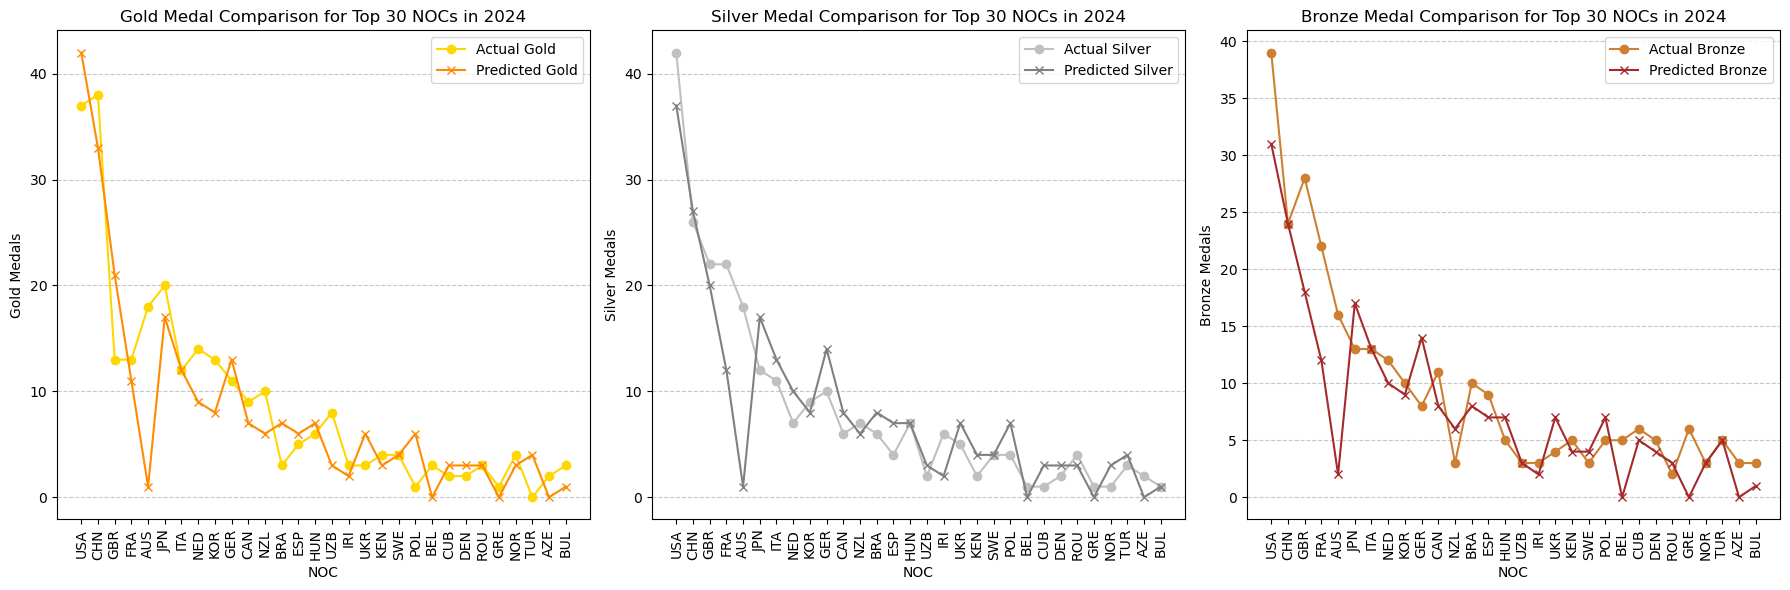

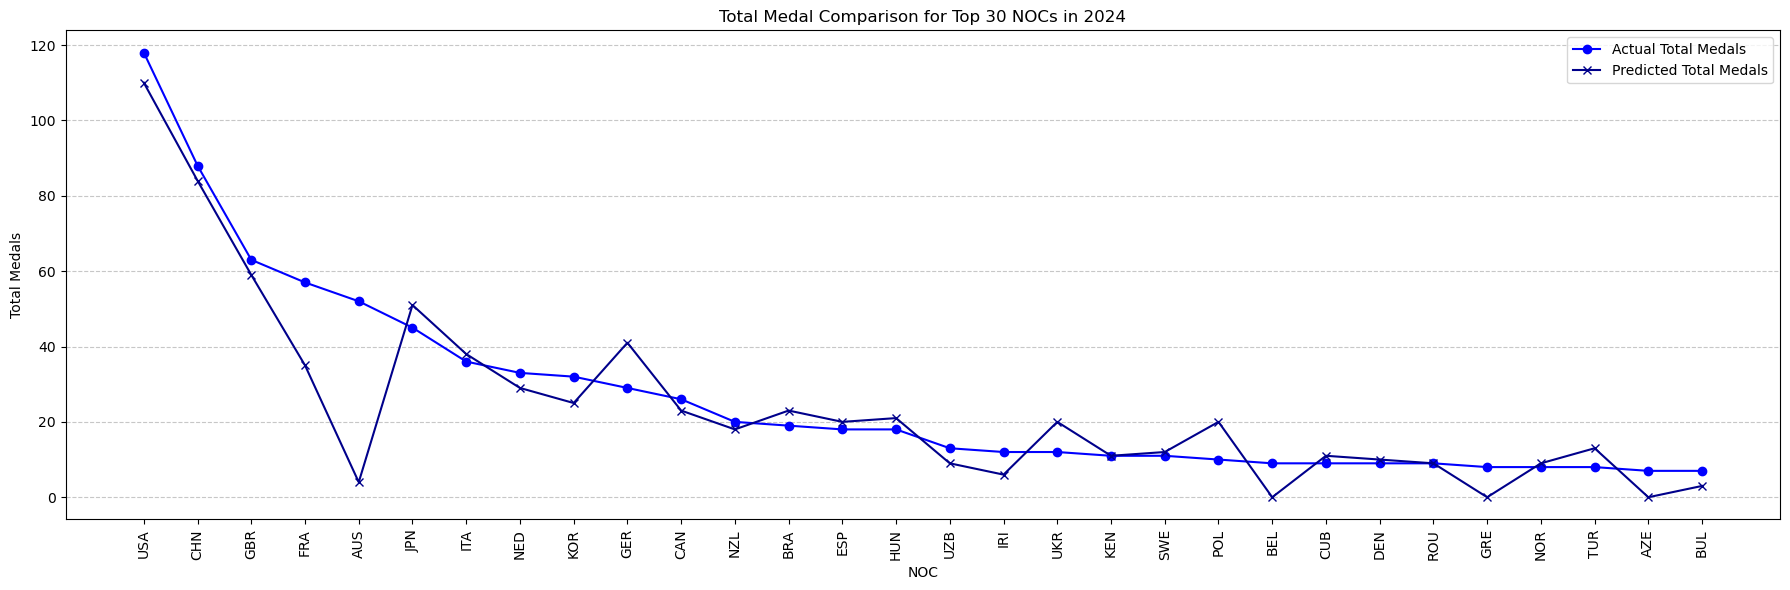

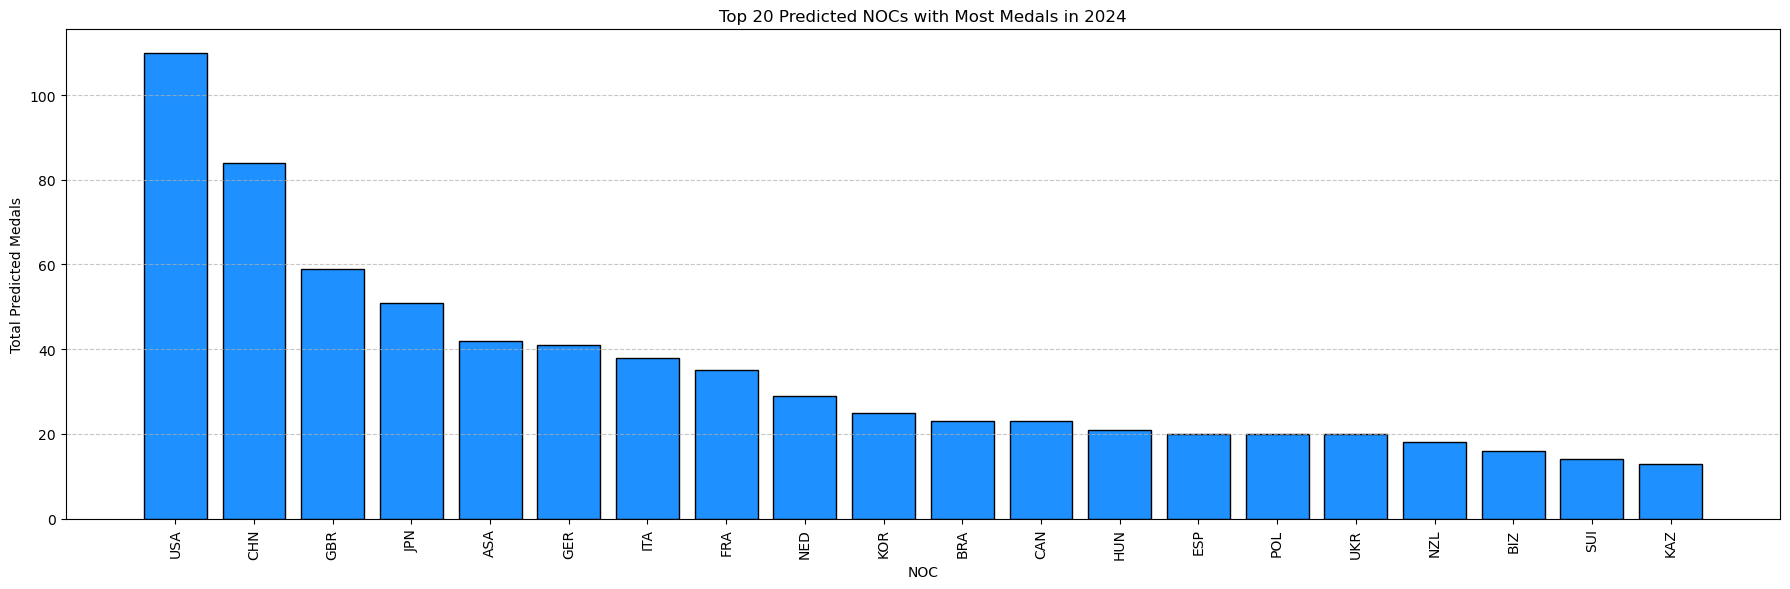

Gold MAE: 0.83
Silver MAE: 0.82
Bronze MAE: 0.97


In [7]:
print("\n**2024 Extrapolated Results**")
visualize_2024_results(df_result_2024, df_noc_year_ohe, ohe_noc, noc_ohe_cols)

E:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[Coverage] Loaded model from my_medal_model_2024.h5
Coverage Rate (%) for each medal type (Gold, Silver, Bronze):
Medal_Gold: 9.22%
Medal_Silver: 9.22%
Medal_Bronze: 9.22%


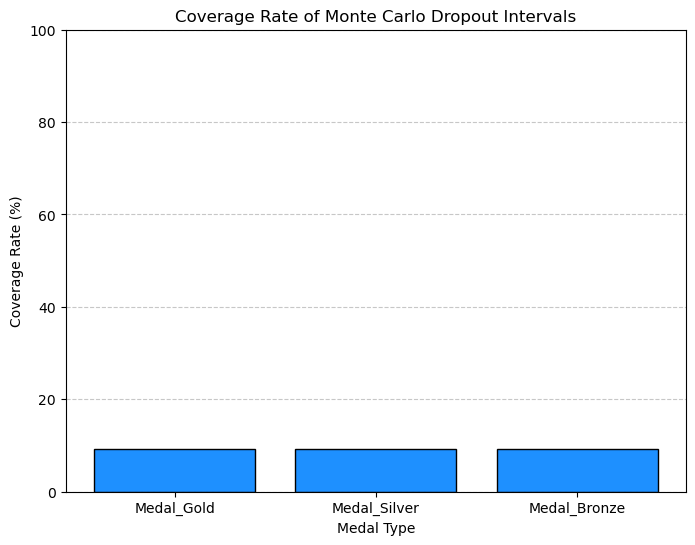

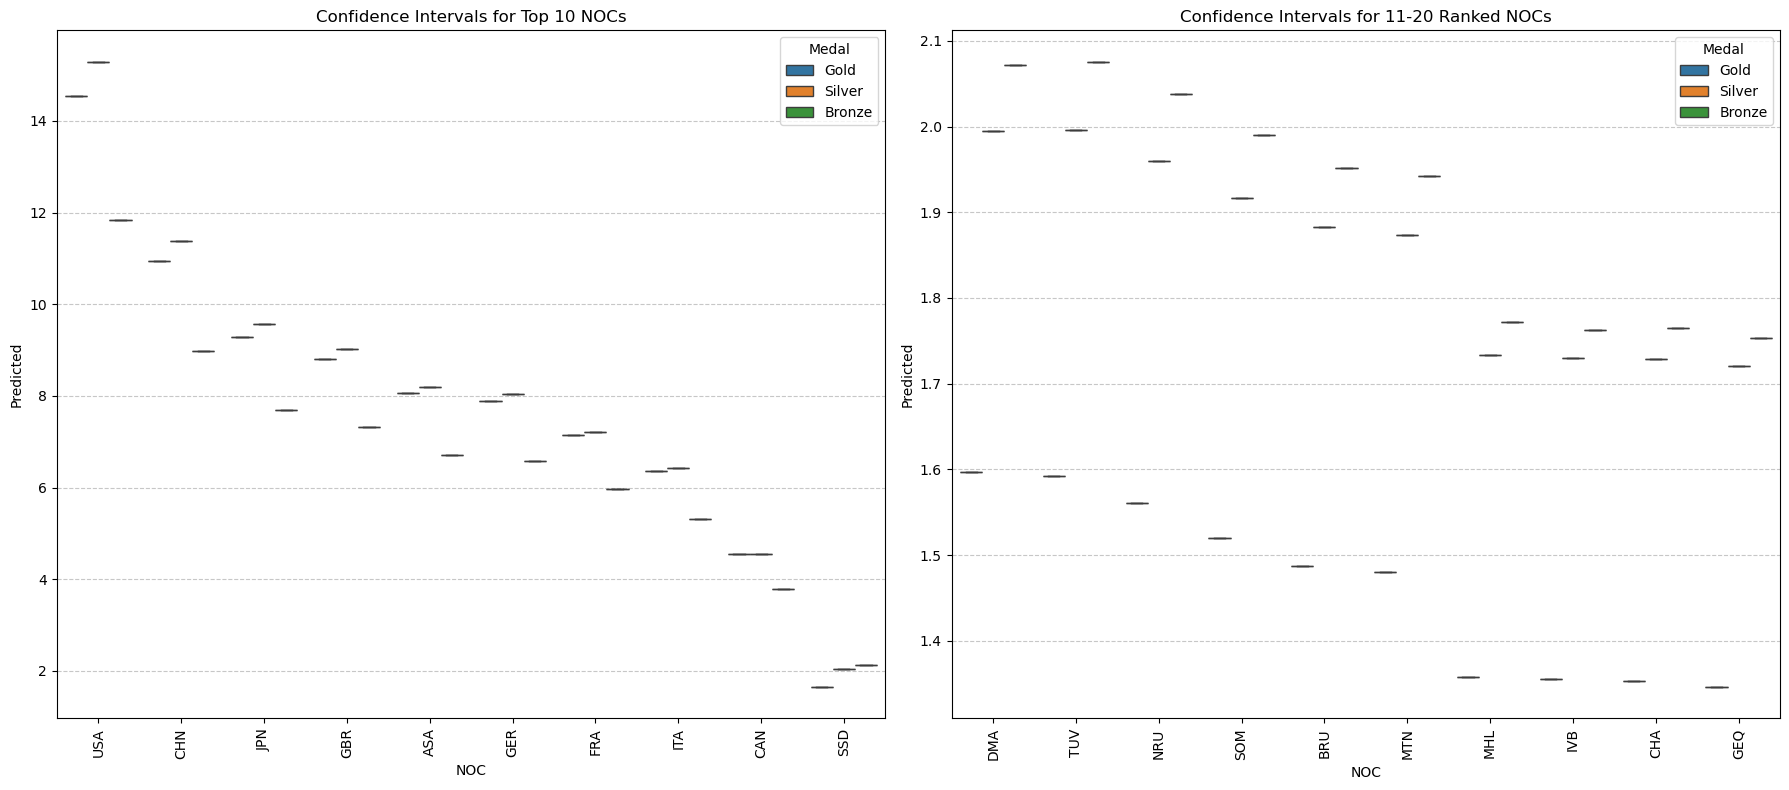

In [21]:
X_2024_for_mc = scaler_features.transform(X_2024_unsc)
actual_2024_for_mc = df_result_2024[["Gold_Actual", "Silver_Actual", "Bronze_Actual"]].values
encoder_path = "noc_encoder.pkl"
ohe_noc = joblib.load(encoder_path)
evaluate_monte_carlo_coverage(
    model_path="my_medal_model_2024.h5",
    X_2024=X_2024_unsc,
    df_2024=df_2024,
    noc_ohe_cols=noc_ohe_cols,
    ohe_noc=ohe_noc,
    actual_2024=actual_2024_for_mc,
    target_cols=target_cols,
    n_sim=1000
)

In [ ]:
# 2) Train up to <2028, LSTM baseline for 2028
model_2028 = train_up_to_2028(X_all, y_all, df_unscaled, feature_cols, target_cols, scaler_targets)
df_result_2028, df_2028_final = build_2028_baseline_and_predict(
    model_2028,
    df_unscaled,
    feature_cols,
    target_cols,
    scaler_features,
    scaler_targets
)

X_2028_for_mc = scaler_features.transform(df_2028_final[feature_cols].values)

model_2028_path = "my_medal_model_2028.h5"
model_2028.save(model_2028_path)
print(f"Model for 2028 saved to {model_2028_path}")

evaluate_monte_carlo_coverage(
    "my_medal_model_2028.h5",
    X_2028_for_mc,
    df_2028,
    noc_ohe_cols,
    ohe_noc,
    actual_2024=None,  # No actual data available for 2028
    target_cols=target_cols,
    n_sim=1000
)

print("\n--- Done with both workflows (2024, 2028) ---")

In [ ]:
##############################################################################
# Workflow #3: Focus Weighted Loss for Potential First Medal
##############################################################################
def focused_first_medal_loss(y_true, y_pred):
    """
    Weighted approach that upweights rows if they had 0 medals last time 
    but are now predicted >=1. 
    We'll skip complicated logic in this final version & keep a simpler demonstration.
    """
    actual_medals = y_true[:,:3]
    had_zero_mask = y_true[:,3]  # last col

    pred_sum = tf.reduce_sum(y_pred, axis=1, keepdims=True)
    cond = tf.logical_and(tf.greater(pred_sum, 0.5), tf.equal(had_zero_mask, 1.0))
    factor = tf.where(cond, 3.0, 1.0)

    base_mae = tf.reduce_mean(tf.abs(actual_medals - y_pred), axis=1)
    weighted = factor * base_mae
    return tf.reduce_mean(weighted)

def build_first_medal_model(input_dim):
    """
    Model specialized for focusing on first-medal countries.
    """
    inputs = Input(shape=(input_dim,))
    x = Dense(2048, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)

    x = Dense(128, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)

    x = Dense(64, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

    x = Dense(32, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

    outputs = Dense(3, activation="linear")(x)
    model = Model(inputs, outputs)

    optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)
    model.compile(optimizer=optimizer, loss=weighted_mae_loss, metrics=["mae"])
    return model

def workflow_first_medal_countries(
    df_agg, 
    feature_cols, 
    scaler_features, 
    model_save_path="focus_first_medal_model.h5"
):
    """
    Build a special y=(MedalGold,MedalSilver,MedalBronze, hadZeroMask),
    train with a specialized focus-first-medal loss,
    then produce a bar chart for countries that might get their first medal.
    """
    # 1) create y_special
    y_3 = df_agg[["Medal_Gold","Medal_Silver","Medal_Bronze"]].values

    # We'll define had0=1 if that row in aggregator had 0 medals last time. 
    # For final demonstration, do a simpler approach:
    had0_mask = (y_3.sum(axis=1)<0.5).astype(int)  # if they have <0.5 => they had0

    y_special = np.hstack([y_3, had0_mask.reshape(-1,1)])

    # 2) X
    X_data = df_agg[feature_cols].values
    X_data_sc = scaler_features.transform(X_data)

    # 3) Train specialized model
    fm_model = build_first_medal_model(len(feature_cols))
    fm_model.fit(X_data_sc, y_special, epochs=200, batch_size=32, verbose=2)
    fm_model.save(model_save_path)
    print(f"[FocusFirstMedal] Model saved => {model_save_path}")

    # 4) Predict sum_of_medals => interpret as probability in [0..1]
    preds_raw = fm_model.predict(X_data_sc)
    sum_pred = preds_raw.sum(axis=1)
    prob_1plus = np.clip(sum_pred/3.0, 0, 1)

    # 5) Identify rows that had0=1 but are predicted to have >=1
    focus_df = df_agg.copy()
    focus_df["prob_1plus"] = prob_1plus
    focus_df["had0"] = had0_mask
    # Filter => had0=1 => might get first medal
    interesting = focus_df[(focus_df["had0"]==1) & (focus_df["prob_1plus"]>0.1)].copy()

    # We'll define a dummy 'NOC_code' if needed
    interesting["NOC_code"] = "???"  
    interesting.sort_values("prob_1plus", ascending=False, inplace=True)

    plt.figure(figsize=(10,6))
    plt.bar(interesting["NOC_code"], interesting["prob_1plus"], color='green', edgecolor='black')
    plt.title("Probability of Getting First-Ever Medal (Focus Workflow #3)")
    plt.xlabel("Country")
    plt.ylabel("Probability (0..1)")
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Save
    interest_csv = "workflow3_first_medal_prob.csv"
    interesting.to_csv(interest_csv, index=False)
    print(f"Saved potential-first-medal DataFrame => {interest_csv}")


##############################################################################
# Workflow #4: For (NOC, Sport, Year) combos
##############################################################################
def specialized_noc_sport_year_workflow(
    df_raw, 
    aggregator,
    combos,
    feature_cols, target_cols,
    scaler_features, scaler_targets
):
    """
    For each (NOC,Year,Sport):
      - Filter row-level data for that NOC+Sport (if needed).
      - Build aggregator up to year< thatYear => train a basic model.
      - Predict for aggregator row=thatYear with actual features => save results
      - If thatYear+4 < 2020 => optionally do the next step as well.
    """
    import os
    os.makedirs("specialized_outputs", exist_ok=True)

    for (thisNOC, thisYear, thisSport) in combos:
        print(f"\n[Workflow#4 Specialized] {thisNOC}, {thisSport}, year={thisYear}")

        # 1) aggregator up to year< thisYear
        sub_agg = aggregator[aggregator["Year"]<thisYear].copy()
        X_sub = scaler_features.transform(sub_agg[feature_cols].values)
        y_sub = scaler_targets.transform(sub_agg[target_cols].values)

        spec_model = build_medal_prediction_model(len(feature_cols))
        es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        rlr= ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
        spec_model.fit(X_sub, y_sub, epochs=300, batch_size=16, verbose=2, callbacks=[es, rlr])

        # 2) predict for aggregator row= thatYear
        rowY = aggregator[aggregator["Year"]==thisYear].copy()
        if not rowY.empty:
            X_that = scaler_features.transform(rowY[feature_cols].values)
            preds_that_sc = spec_model.predict(X_that)
            preds_that = scaler_targets.inverse_transform(preds_that_sc)

            df_pred = pd.DataFrame({
                "NOC": [thisNOC],
                "Sport": [thisSport],
                "Year": [thisYear],
                "Gold_Predicted": [preds_that[0,0]],
                "Silver_Predicted": [preds_that[0,1]],
                "Bronze_Predicted": [preds_that[0,2]],
            })
            out_csv = f"specialized_outputs/pred_{thisNOC}_{thisSport}_{thisYear}.csv"
            df_pred.to_csv(out_csv, index=False)
            print(f"Saved => {out_csv}")
        else:
            print("No aggregator row found => skip first prediction")

        # 3) if nextYear<2020 => second step
        nextYear = thisYear+4
        if nextYear<2020:
            sub_agg2 = aggregator[aggregator["Year"]<nextYear].copy()
            X_sub2 = scaler_features.transform(sub_agg2[feature_cols].values)
            y_sub2 = scaler_targets.transform(sub_agg2[target_cols].values)

            spec_model2 = build_medal_prediction_model(len(feature_cols))
            spec_model2.fit(X_sub2, y_sub2, epochs=300, batch_size=16, verbose=0)

            rowY2 = aggregator[aggregator["Year"]==nextYear].copy()
            if not rowY2.empty:
                X_that2 = scaler_features.transform(rowY2[feature_cols].values)
                pred_sc2 = spec_model2.predict(X_that2)
                pred2 = scaler_targets.inverse_transform(pred_sc2)

                df_pred2 = pd.DataFrame({
                    "NOC": [thisNOC],
                    "Sport": [thisSport],
                    "Year": [nextYear],
                    "Gold_Predicted": [pred2[0,0]],
                    "Silver_Predicted": [pred2[0,1]],
                    "Bronze_Predicted": [pred2[0,2]],
                })
                out2 = f"specialized_outputs/pred_{thisNOC}_{thisSport}_{nextYear}.csv"
                df_pred2.to_csv(out2, index=False)
                print(f"Saved => {out2}")
            else:
                print("No aggregator row for second step => skip")

        # Save specialized model
        model_path = f"specialized_outputs/model_{thisNOC}_{thisSport}_{thisYear}.h5"
        spec_model.save(model_path)
        print(f"Saved specialized model => {model_path}")


##############################################################################
# Workflow #5: Analyze Proportion of Each Sport & Correlations
##############################################################################
def analyze_sport_proportions(df_raw, aggregator, out_csv="sport_proportion_corr.csv"):
    """
    For each NOC, get fraction of medals from each sport across row-level data,
    produce correlation matrix with 'TotalMedals', save to CSV, and show heatmap.
    """
    df_temp = df_raw.copy()
    # define medal_count => 1 if medal in {Gold,Silver,Bronze}, else 0
    df_temp["medal_count"] = df_temp["Medal"].apply(lambda m: 1 if m in ["Gold","Silver","Bronze"] else 0)

    # pivot => (NOC, Sport)=> sum(medal_count)
    pivot = df_temp.groupby(["NOC","Sport"])["medal_count"].sum().reset_index()
    # total by NOC
    total_by_noc = pivot.groupby("NOC")["medal_count"].sum().reset_index(name="TotalMedals")
    pivot = pivot.merge(total_by_noc, on="NOC", how="left")
    pivot["Frac"] = pivot["medal_count"]/ pivot["TotalMedals"].replace(0,1)  # avoid div0

    # pivot wide => columns=Sport => fraction
    wide = pivot.pivot(index="NOC", columns="Sport", values="Frac").fillna(0)
    # also store total
    tm = pivot.drop_duplicates("NOC")[["NOC","TotalMedals"]]
    wide = wide.merge(tm, on="NOC", how="left")

    corr = wide.corr()
    corr.to_csv(out_csv)
    print(f"Saved correlation matrix => {out_csv}")

    plt.figure(figsize=(12,10))
    sns.heatmap(corr, annot=False, cmap="RdBu", center=0)
    plt.title("Correlation: Sport Fractions vs. Total Medals")
    plt.tight_layout()
    plt.show()


##############################################################################
# Putting It All Together
##############################################################################
def run_new_workflows(df_raw, aggregator):
    """
    1) Workflow #3 => specialized "first medal" focus
    2) Workflow #4 => specialized combos for (NOC, Sport, Year)
    3) Workflow #5 => analyze sport proportion correlation
    """
    # Suppose you have the same feature_cols, target_cols as your aggregator uses:
    feature_cols = df_noc_year_ohe.columns.difference(["Year"] + target_cols)
    target_cols = ["Medal_Gold", "Medal_Silver", "Medal_Bronze"]


    # Load or reuse your scalers:
    with open("scaler_features.pkl","rb") as f:
        sc_feat = pickle.load(f)
    with open("scaler_targets.pkl","rb") as f:
        sc_targ = pickle.load(f)

    # 1) Workflow #3 => first medal
    workflow_first_medal_countries(
        aggregator,
        feature_cols,
        sc_feat,
        model_save_path="focus_first_medal_model.h5"
    )

    # 2) Workflow #4 => specialized combos
    combos = [
        ("FRA", 2016, "Gymnastics"),
        ("USA", 2020, "Gymnastics"),
        ("JPN", 2008, "Artistic Swimming"),
        ("CHN", 2012, "Artistic Swimming"),
        ("CHN", 2008, "Volleyball"),
        ("USA", 2012, "Volleyball")
    ]
    specialized_noc_sport_year_workflow(
        df_raw, aggregator,
        combos,
        feature_cols, target_cols,
        sc_feat, sc_targ
    )

    # 3) Workflow #5 => proportion correlation
    analyze_sport_proportions(df_raw, aggregator, out_csv="sport_proportion_corr.csv")

In [ ]:
run_new_workflows(df, df_noc_year_ohe)